In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer

/Users/hamzaimamovic/Library/Python/3.12/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
# df = pd.read_pickle('data/perfumes.pkl')
df = pd.read_pickle('encoded_perfumes.pkl')
df.drop(columns=["collection", "top_notes", "middle_notes", "base_notes", "all_notes"], inplace=True)
df.drop(columns=["url", "Duft.number_of_ratings", "Haltbarkeit.number_of_ratings", "Sillage.number_of_ratings", "Flakon.number_of_ratings", "Preis-Leistungs-Verhältnis.number_of_ratings"], inplace=True)

drop_list = []
for i in range(0,11):
    drop_list.append(f'scent.{i}')
    drop_list.append(f'sillage.{i}')
    drop_list.append(f'durability.{i}')
    drop_list.append(f'pricing.{i}')
    drop_list.append(f'bottle.{i}')

df.drop(columns=drop_list, inplace=True)

df.head()

,name,brand,year,flakon_designer,perfumer,Duft.rating,Haltbarkeit.rating,Sillage.rating,Flakon.rating,Preis-Leistungs-Verhältnis.rating,...,ägyptisches Neroli,ägyptisches Rosengeranienblatt,ägyptisches Veilchen,ägyptisches Veilchenblatt,ägyptisches Veilchenblatt Absolue,äthiopische Myrrhe,äthiopischer Kaffee,äthiopischer Kaffee Absolue,äthiopischer Weihrauch,äthiopischer Zibet
0,Remix Cologne Anniversary Edition,4711,2017.0,None,Alexandra Kalle,8.0,5.5,5.6,7.5,7.9,...,0,0,0,0,0,0,0,0,0,0
1,Solarissimo - Levanzo,Azzaro,2016.0,None,None,6.6,5.6,5.2,7.2,NaN,...,0,0,0,0,0,0,0,0,0,0
2,A*Men Ultra Zest,Mugler,2015.0,None,Jacques Huclier,7.7,7.6,7.1,7.0,6.8,...,0,0,0,0,0,0,0,0,0,0
3,Acqua Nobile Rosa,Acqua di Parma,2015.0,None,None,7.2,6.4,5.9,7.8,NaN,...,0,0,0,0,0,0,0,0,0,0
4,Minuit et Demi,Fragrance Du Bois,2021.0,None,Stéphane Bengana,7.5,6.7,6.1,8.5,4.9,...,0,0,0,0,0,0,0,0,0,0


### Encode name brand and year

In [5]:
encoded_dfs = [df.copy()]


for col in ['brand', 'perfumer', 'flakon_designer']:
    # Replace NaN with None (optional, as get_dummies handles NaN properly)
    df[col] = df[col].apply(lambda x: x if pd.notna(x) else None)
    
    # Get dummies and prefix column names
    dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=False).astype(int)
    
    # Append to our list of dataframes
    encoded_dfs.append(dummies)

# Concatenate all dataframes horizontally
df_encoded = pd.concat(encoded_dfs, axis=1)

df = df_encoded

# Print final DataFrame
print(df)

                                      name              brand    year  \
0        Remix Cologne Anniversary Edition               4711  2017.0   
1                    Solarissimo - Levanzo             Azzaro  2016.0   
2                         A*Men Ultra Zest             Mugler  2015.0   
3                        Acqua Nobile Rosa     Acqua di Parma  2015.0   
4                           Minuit et Demi  Fragrance Du Bois  2021.0   
...                                    ...                ...     ...   
13984                              Hartley          Mazzolari  2014.0   
13985                           Gethsemane        Adi ale Van  2023.0   
13986  Bentley Infinite Rush White Edition            Bentley  2016.0   
13987                    Olibanum Gardenia           Bohoboco  2016.0   
13988              Obelisk MCM 1985 Parfum                MCM  1985.0   

                                         flakon_designer  \
0                                                   None   
1  

In [6]:
numeric_df = df.drop(columns=['name', 'brand', 'year', 'flakon_designer', 'perfumer'])

feature_df = numeric_df.drop(columns=['Duft.rating', 'Haltbarkeit.rating', 'Sillage.rating', 'Flakon.rating', 'Preis-Leistungs-Verhältnis.rating'])

In [7]:
feature_df.fillna(0, inplace=True)

In [8]:
feature_df.info
feature_df.isna().any().any()
df[df.isna().any(axis=1)]

,name,brand,year,flakon_designer,perfumer,Duft.rating,Haltbarkeit.rating,Sillage.rating,Flakon.rating,Preis-Leistungs-Verhältnis.rating,...,"flakon_designer_Flakondesign Wolfgang Joop, Studio Pi Design",flakon_designer_Flakondesign Yves Fajnberg,flakon_designer_Flakondesign Zhong Xiao,flakon_designer_Flakondesign kA,flakon_designer_Flakondesign kissmiklos,"flakon_designer_Flakondesign nada for nada, Alessandro Reggioli",flakon_designer_Flakondesign tátil*,flakon_designer_Flakondesign unbekannt,"flakon_designer_Flakondesign Åsa Jungnelius, Kosta Boda",flakon_designer_Serge Mansau
0,Remix Cologne Anniversary Edition,4711,2017.0,None,Alexandra Kalle,8.0,5.5,5.6,7.5,7.9,...,0,0,0,0,0,0,0,0,0,0
1,Solarissimo - Levanzo,Azzaro,2016.0,None,None,6.6,5.6,5.2,7.2,NaN,...,0,0,0,0,0,0,0,0,0,0
2,A*Men Ultra Zest,Mugler,2015.0,None,Jacques Huclier,7.7,7.6,7.1,7.0,6.8,...,0,0,0,0,0,0,0,0,0,0
3,Acqua Nobile Rosa,Acqua di Parma,2015.0,None,None,7.2,6.4,5.9,7.8,NaN,...,0,0,0,0,0,0,0,0,0,0
4,Minuit et Demi,Fragrance Du Bois,2021.0,None,Stéphane Bengana,7.5,6.7,6.1,8.5,4.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13984,Hartley,Mazzolari,2014.0,None,None,8.4,8.1,7.6,7.0,7.5,...,0,0,0,0,0,0,0,0,0,0
13985,Gethsemane,Adi ale Van,2023.0,Flakondesign Adi Ale Van,David-Lev Jipa Slivinschi a.k.a. Toskovat' Par...,8.2,9.2,8.2,8.7,NaN,...,0,0,0,0,0,0,0,0,0,0
13986,Bentley Infinite Rush White Edition,Bentley,2016.0,"Flakondesign Thierry de Baschmakoff, Pochet du...",None,7.8,6.7,6.6,7.4,NaN,...,0,0,0,0,0,0,0,0,0,0
13987,Olibanum Gardenia,Bohoboco,2016.0,"Flakondesign Kamil Owczarek, Michał Gilbert Lach",None,7.6,7.7,7.0,7.6,6.3,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# numeric_columns = ["Zitrus", "Würzig", "Grün", "Fruchtig", "Frisch", "Blumig", "Synthetisch", "Süß", "Holzig", "Aquatisch", "Gourmand", "Pudrig", "Orientalisch", "Cremig", "Ledrig", "Harzig", "Rauchig", "Animalisch", "Fougère", "Chypre"]

# X = df[numeric_columns]
X = feature_df

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Reduce to 2D
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Perfume'] = df['name']  # Assuming 'name' column has perfume names
df_pca['Brand'] = df['brand']  # Optional: Include brand for coloring

In [12]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     x=df_pca['PC1'], y=df_pca['PC2'], 
#     hue=df_pca['Brand'],  # Optional: Color by brand
#     palette='tab10', alpha=0.7, edgecolor='black'
# )

# # Annotate each perfume on the scatterplot
# for i in range(len(df_pca)):
#     plt.text(df_pca['PC1'][i], df_pca['PC2'][i], df_pca['Perfume'][i], fontsize=8, alpha=0.7)

# plt.title("Perfume PCA - 2D Projection")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend
# plt.show()

In [13]:
selected_perfumes = [
    "Sauvage", 
    "Bleu de Chanel", 
    "Aventus",
    "Oud Wood Tom Ford 2007 Eau de Parfum",
    "Tobacco Vanille Tom Ford 2007 Eau de Parfum",
    "Ombré Leather Tom Ford 2018 Eau de Parfum",
    "Le Male", 
    "La Nuit de L'Homme",
    "Dior Homme Dior 2020 Eau de Toilette",
    "Dior Homme Intense",
    "Dior Homme Original Dior 2011 Eau de Toilette",
    "Dior Homme Parfum",
    "Dior Homme Sport",
    "Sauvage Dior 2015 Eau de Toilette",
    "Sauvage Dior 2018 Eau de Parfum",
    "Sauvage Elixir",
    "Sauvage Parfum",
    "40 Knots",
    "Alexandria II XerJoff 2012 Parfum",
    "Erba Pura",
    "Naxos"
    ]

df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes)]


In [14]:
selected_perfumes_man = ['Imagination', 'Layton', 'Dior Homme Intense (2011)', 'Aventus', "L'Homme", 'Reflection Man', 'Spicebomb Extreme', "La Nuit de L'Homme  Eau de Toilette", 'Le Mâle Le Parfum', 'The One for Men  Eau de Parfum', 'Acqua di Giò Profumo  Parfum', 'Noir Extreme  Eau de Parfum', 'Bleu de Chanel  Eau de Parfum', 'Dior Homme Parfum (2014)', 'Althaïr', "Terre d'Hermès  Eau de Toilette", 'Allure Homme Sport Eau Extrême', 'Emporio Armani - Stronger with You Intensely', "L'Homme Idéal  Eau de Parfum", 'Allure Homme Édition Blanche  Eau de Parfum', 'Elysium Parfum Cologne  Eau de Parfum', 'Luna Rossa Black', 'Sauvage Elixir', 'Le Mâle Elixir', 'Jubilation XXV Man', 'Sauvage  Eau de Toilette', 'Layton Exclusif', 'Valentino Uomo Intense (2016)', 'Bleu de Chanel Parfum', "La Nuit de L'Homme Bleu Électrique", 'Ultra Mâle', 'Dior Homme Original (2011)  Eau de Toilette', "L'Homme Intense", 'Turathi (Blue)', 'Sunrise on the Red Sand Dunes  Eau de Parfum', 'Le Mâle  Eau de Toilette', 'Versace pour Homme Dylan Blue  Eau de Toilette', 'Elysium pour Homme  Parfum', 'Encre Noire  Eau de Toilette', 'Green Irish Tweed', "Terre d'Hermès  Parfum", 'Reflection 45', 'Club de Nuit Intense Man  Eau de Toilette', 'Jump Up and Kiss Me Hedonistic', 'Fahrenheit  Eau de Toilette', 'Eros  Eau de Toilette', 'Explorer', 'Jazz Club', "L'Instant de Guerlain pour Homme  Eau de Parfum", 'Égoïste  Eau de Toilette', 'Sauvage  Eau de Parfum', 'Sedley', 'Percival', 'Gentleman Givenchy Réserve Privée', 'Club Black', 'Y  Eau de Parfum', 'Acqua di Giò pour Homme  Eau de Toilette', 'Allure Homme Sport  Eau de Toilette', 'Bleu de Chanel  Eau de Toilette', 'Emporio Armani - Stronger With You Absolutely', 'Enigma pour Homme  Parfum', 'A*Men Pure Havane', 'Boss Bottled  Eau de Toilette', 'Haltane', 'masculin Pluriel', 'Platinum Égoïste  Eau de Toilette', 'Bentley for Men Intense', 'Light Blue pour Homme Eau Intense', '9pm', 'Gentleman Givenchy  Eau de Parfum', 'Beau de Jour  Eau de Parfum', 'Eros Flame', 'Moustache  Eau de Parfum', 'Oud for Glory', 'Spicebomb', 'Cool Water  Eau de Toilette', 'Interlude Man', 'Antaeus  Eau de Toilette', 'Pardon  Extrait de Parfum', 'Oud Save the King  Eau de Parfum', 'Missoni Wave', 'Sun Men  Eau de Toilette', 'Dior Homme Cologne (2013)', 'Versace pour Homme  Eau de Toilette', 'Intoxicated', 'Epic Man', "L'Homme  Eau de Toilette", 'Asad', "Terre d'Hermès Eau Givrée", 'Eau Sauvage  Eau de Toilette', 'The Dreamer  Eau de Toilette', 'Club de Nuit Intense Man Limited Edition', 'Le Beau Le Parfum', 'Hawas for Him', 'The Most Wanted Parfum']
selected_perfumes_uni = ['Naxos', 'Alexandria II  Parfum', 'Oud Wood  Eau de Parfum', 'Grand Soir', 'Herod', "Angels' Share  Eau de Parfum", 'London  Extrait de Parfum', '40 Knots', 'Torino21', 'Tobacco Vanille  Eau de Parfum', 'Side Effect', 'Ombre Nomade', 'Accento', 'Tony Iommi Monkey Special', 'Oajan', 'Afternoon Swim', 'Casamorati - Lira  Eau de Parfum', 'Ombré Leather (2018)  Eau de Parfum', 'Lost Cherry  Eau de Parfum', 'Uden', 'Ani  Extrait de Parfum', 'Oud Satin Mood  Eau de Parfum', 'Ambre Nuit  Eau de Parfum', 'Baccarat Rouge 540  Eau de Parfum', 'Virgin Island Water', 'XXI: Art Deco - Blonde Amber', 'Baccarat Rouge 540  Extrait de Parfum', 'Erba Pura', 'Oud for Greatness  Eau de Parfum', 'Carlisle', 'Wūlóng Chá  Extrait de Parfum', 'Hacivat', 'Angélique Noire', 'Nefs', 'Khamrah', 'Salam', 'Fucking Fabulous  Eau de Parfum', 'By the Fireplace', 'Tuscan Leather  Eau de Parfum', 'Ganymede  Eau de Parfum', 'Arabians Tonka', "№ 02 - L'Air du Désert Marocain  Eau de Toilette Intense", 'Black Afgano  Extrait de Parfum', 'Cuir Béluga  Eau de Parfum', 'Gris Charnel  Eau de Parfum', 'Gentle Fluidity (Silver)', 'Amber Star', 'Pegasus', 'Baraonda  Extrait de Parfum', 'Détour Noir', 'Orange Flamingo', 'Khaltat Night  Eau de Parfum', 'Pacific Rock Moss', 'Musc Ravageur  Eau de Parfum', 'Rehab', 'Fico di Amalfi', 'Musk Therapy  Extrait de Parfum', 'Oud Satin Mood  Extrait de Parfum', 'Spiritueuse Double Vanille', "Bal d'Afrique  Eau de Parfum", 'Au Coeur du Désert', 'Tonka Impériale', 'Malibù - Party in the Bay', 'Bois Impérial  Eau de Parfum', 'Royal Oud', 'Pacific Chill', 'Renaissance', 'Black Tie  Eau de Parfum', 'Red Tobacco', 'Isola Blu  Parfum', 'Kirkè  Extrait de Parfum', 'Chergui  Eau de Parfum', 'Amber Aoud  Parfum', 'Gris Charnel  Extrait', 'Noir de Noir  Eau de Parfum', 'Sillage', 'Oud Maracujá', '17 Rosso', 'Arabesque', 'Pomelo Sorrento', 'Ishq', 'Mandarino di Amalfi  Eau de Parfum', 'Le Vestiaire - Tuxedo', 'African Leather  Eau de Parfum', 'Aventus Cologne', 'Richwood', 'Cedrat Boise', 'Wood Sage & Sea Salt  Cologne', 'Opera', 'Molecule 01', 'Black Orchid  Eau de Parfum', 'Coromandel  Eau de Parfum', 'Liam', 'A Midsummer Dream', '5 - Floral, Amber, Sensual Musk  Eau de Parfum', 'Triumph of Bacchus  Eau de Parfum', 'Shaghaf Oud  Eau de Parfum', 'Alexandria III', 'Gris Dior  Eau de Parfum', "Bois d'Argent"]

with open('male_perfumes.json', 'r') as f:
    selected_perfumes_man = json.load(f)
with open('uni_perfumes.json', 'r') as f:
    selected_perfumes_uni = json.load(f)

/var/folders/lq/blpghcxd0b9cm2tsrvlqq9g40000gn/T/ipykernel_86635/2369301565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca_filtered['Type'] = df_pca_filtered['Perfume'].apply(lambda x: 'Man' if x in selected_perfumes_man else 'Unisex')


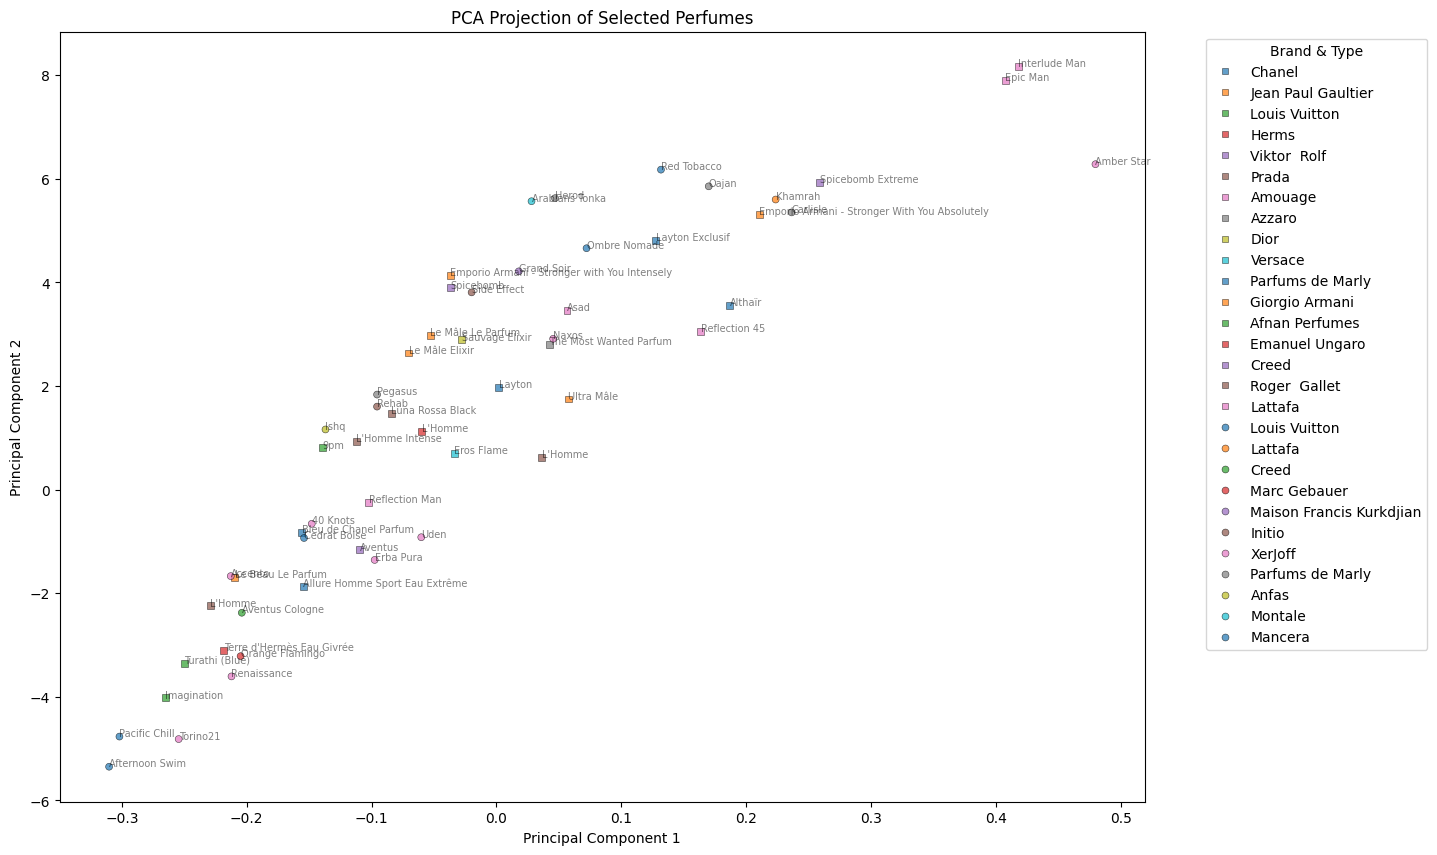

In [15]:
# Create a new column for classification
df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes_man + selected_perfumes_uni)]
df_pca_filtered['Type'] = df_pca_filtered['Perfume'].apply(lambda x: 'Man' if x in selected_perfumes_man else 'Unisex')

plt.figure(figsize=(14, 10))

# Define markers for different types
markers = {'Man': 's', 'Unisex': 'o'}  # Circle for men, square for unisex

# Plot manually for each category
for t, marker in markers.items():
    subset = df_pca_filtered[df_pca_filtered['Type'] == t]
    sns.scatterplot(
        x=subset['PC1'], y=subset['PC2'], 
        hue=subset['Brand'], palette='tab10', alpha=0.7, edgecolor='black', 
        marker=marker, s=25
    )

# Annotate each perfume
for i in range(len(df_pca_filtered)):
    plt.text(df_pca_filtered['PC1'].iloc[i], df_pca_filtered['PC2'].iloc[i], 
             df_pca_filtered['Perfume'].iloc[i], fontsize=7, alpha=0.5)

plt.title("PCA Projection of Selected Perfumes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Brand & Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [16]:
df_pca_filtered

,PC1,PC2,Perfume,Brand,Type
337,-0.154835,-1.868806,Allure Homme Sport Eau Extrême,Chanel,Man
380,0.057722,1.749440,Ultra Mâle,Jean Paul Gaultier,Man
531,-0.301919,-4.767958,Pacific Chill,Louis Vuitton,Unisex
938,-0.265161,-4.022085,Imagination,Louis Vuitton,Man
992,0.223697,5.601100,Khamrah,Lattafa,Unisex
1349,-0.203909,-2.377241,Aventus Cologne,Creed,Unisex
1517,-0.218534,-3.103476,Terre d'Hermès Eau Givrée,Herms,Man
1585,-0.036594,3.894896,Spicebomb,Viktor Rolf,Man
1588,-0.209487,-1.698271,Le Beau Le Parfum,Jean Paul Gaultier,Man
1802,-0.229100,-2.246115,L'Homme,Prada,Man


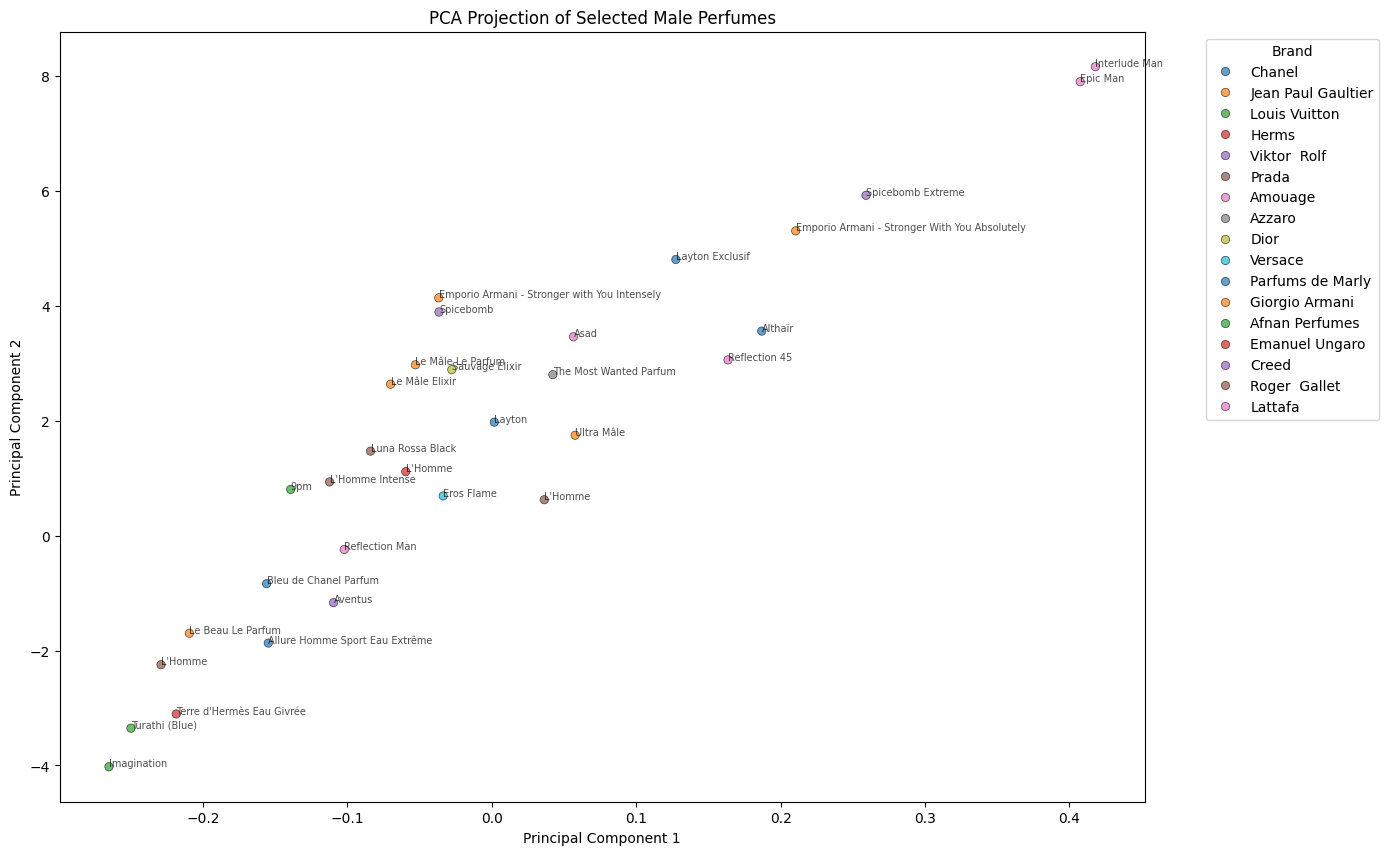

In [17]:
# df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes)]
df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes_man)]

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=df_pca_filtered['PC1'], y=df_pca_filtered['PC2'], 
    hue=df_pca_filtered['Brand'],  # Optional: Color by brand
    palette='tab10', alpha=0.7, edgecolor='black'
)

# Annotate each selected perfume
for i in range(len(df_pca_filtered)):
    plt.text(df_pca_filtered['PC1'].iloc[i], df_pca_filtered['PC2'].iloc[i], 
             df_pca_filtered['Perfume'].iloc[i], fontsize=7, alpha=0.7)

plt.title("PCA Projection of Selected Male Perfumes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

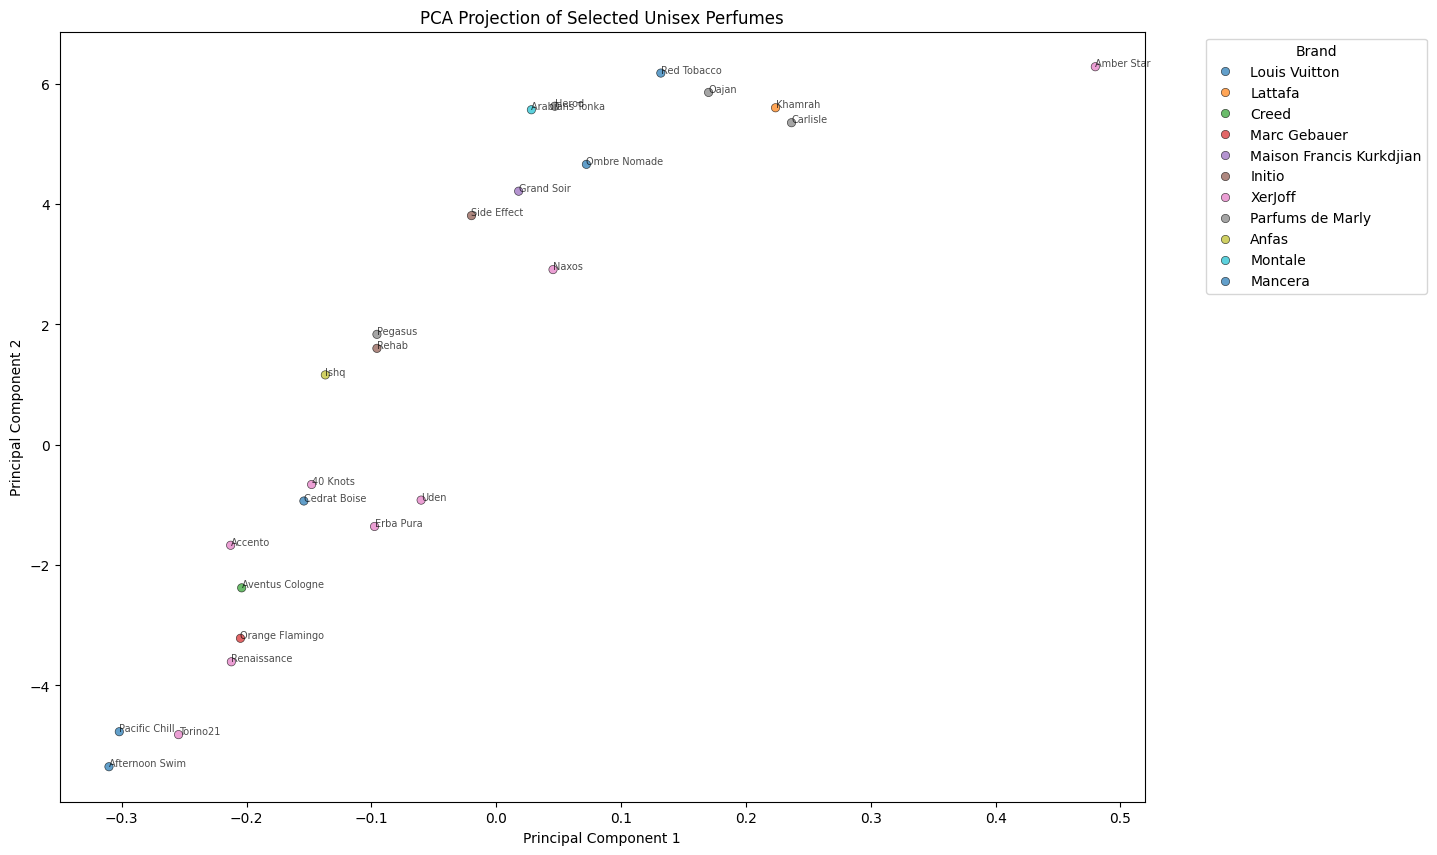

In [18]:
df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes_uni)]

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=df_pca_filtered['PC1'], y=df_pca_filtered['PC2'], 
    hue=df_pca_filtered['Brand'],  # Optional: Color by brand
    palette='tab10', alpha=0.7, edgecolor='black'
)

# Annotate each selected perfume
for i in range(len(df_pca_filtered)):
    plt.text(df_pca_filtered['PC1'].iloc[i], df_pca_filtered['PC2'].iloc[i], 
             df_pca_filtered['Perfume'].iloc[i], fontsize=7, alpha=0.7)

plt.title("PCA Projection of Selected Unisex Perfumes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/lq/blpghcxd0b9cm2tsrvlqq9g40000gn/T/ipykernel_86635/2164003034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca_filtered['Type'] = df_pca_filtered['Perfume'].apply(lambda x: 'Man' if x in selected_perfumes_man else 'Unisex')


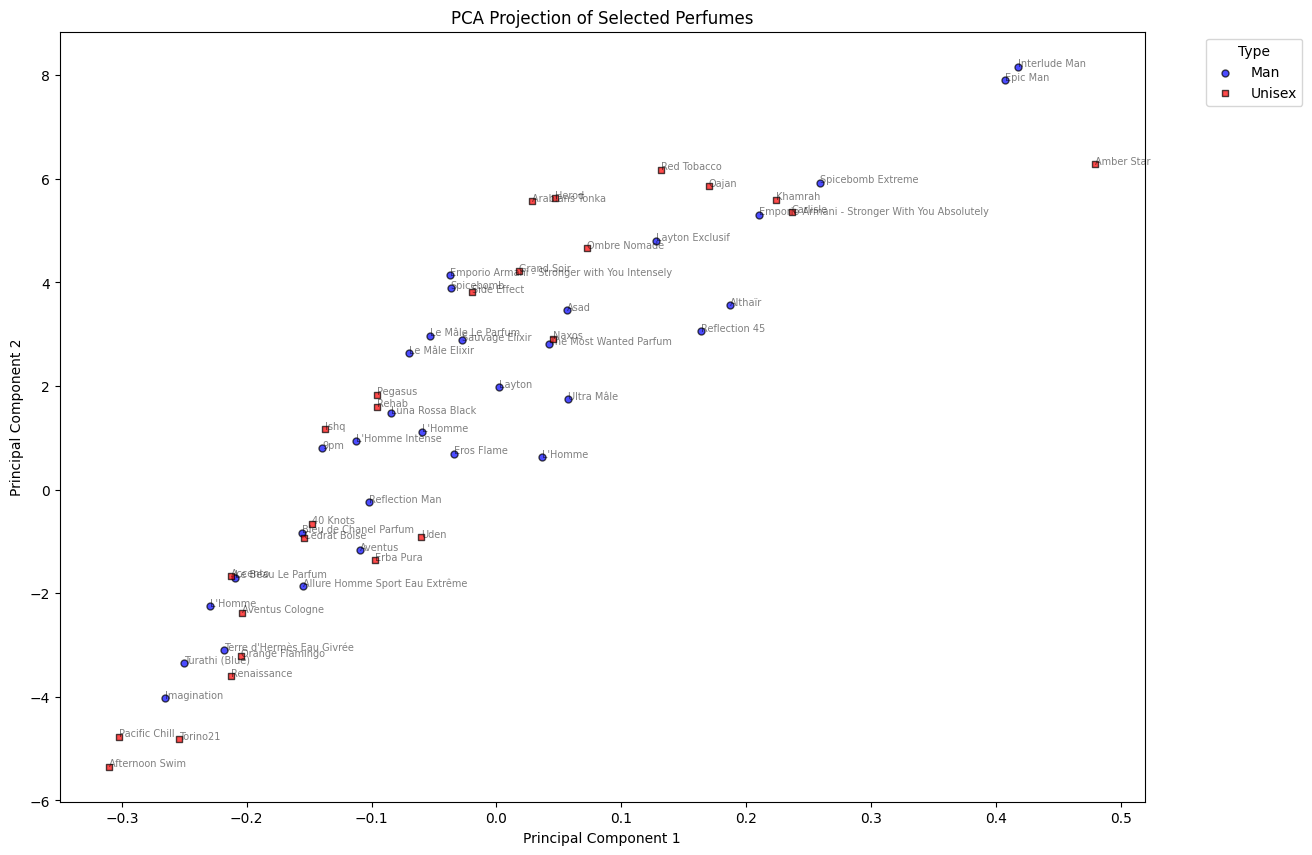

In [19]:
# Create a new column for classification
df_pca_filtered = df_pca[df_pca['Perfume'].isin(selected_perfumes_man + selected_perfumes_uni)]
df_pca_filtered['Type'] = df_pca_filtered['Perfume'].apply(lambda x: 'Man' if x in selected_perfumes_man else 'Unisex')

plt.figure(figsize=(14, 10))

# Define colors and markers for different types
colors = {'Man': 'blue', 'Unisex': 'red'}
markers = {'Man': 'o', 'Unisex': 's'}  # Circle for men, square for unisex

# Plot manually for each category
for t in ['Man', 'Unisex']:
    subset = df_pca_filtered[df_pca_filtered['Type'] == t]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        c=colors[t], label=t, marker=markers[t], edgecolors='black', alpha=0.7, s=25
    )

# Annotate each perfume
for i in range(len(df_pca_filtered)):
    plt.text(df_pca_filtered['PC1'].iloc[i], df_pca_filtered['PC2'].iloc[i], 
             df_pca_filtered['Perfume'].iloc[i], fontsize=7, alpha=0.5)

plt.title("PCA Projection of Selected Perfumes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
selected_brands = ["Dior", "Chanel", "Tom Ford", "Creed", "Yves Saint Laurent", "Lattafa", "Afnan", 
                   "XerJoff", "Mancera", "Lattafa Pride", "Initio", "Amouage", "Giorgio Armani", "Prada"]

df_pca_filtered = df_pca[df_pca['Brand'].isin(selected_brands)]

brand_centroids = df_pca_filtered.groupby('Brand')[['PC1', 'PC2']].mean().reset_index()

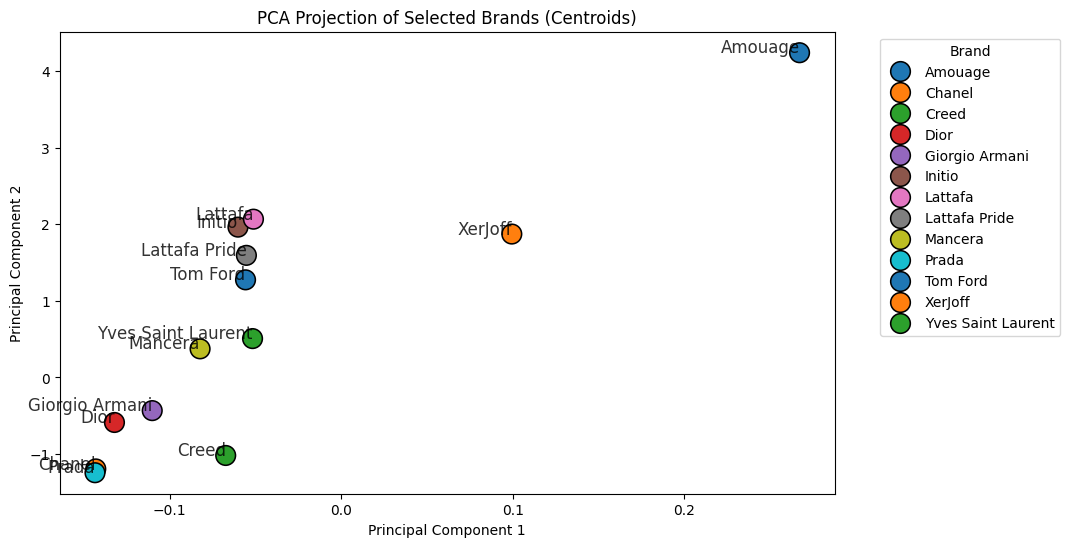

In [21]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=brand_centroids['PC1'], y=brand_centroids['PC2'], 
    hue=brand_centroids['Brand'], palette='tab10', 
    s=200, edgecolor='black'  # Larger markers for visibility
)

# Annotate each brand at its centroid
for i in range(len(brand_centroids)):
    plt.text(brand_centroids['PC1'].iloc[i], brand_centroids['PC2'].iloc[i], 
             brand_centroids['Brand'].iloc[i], fontsize=12, ha='right', alpha=0.8)

plt.title("PCA Projection of Selected Brands (Centroids)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

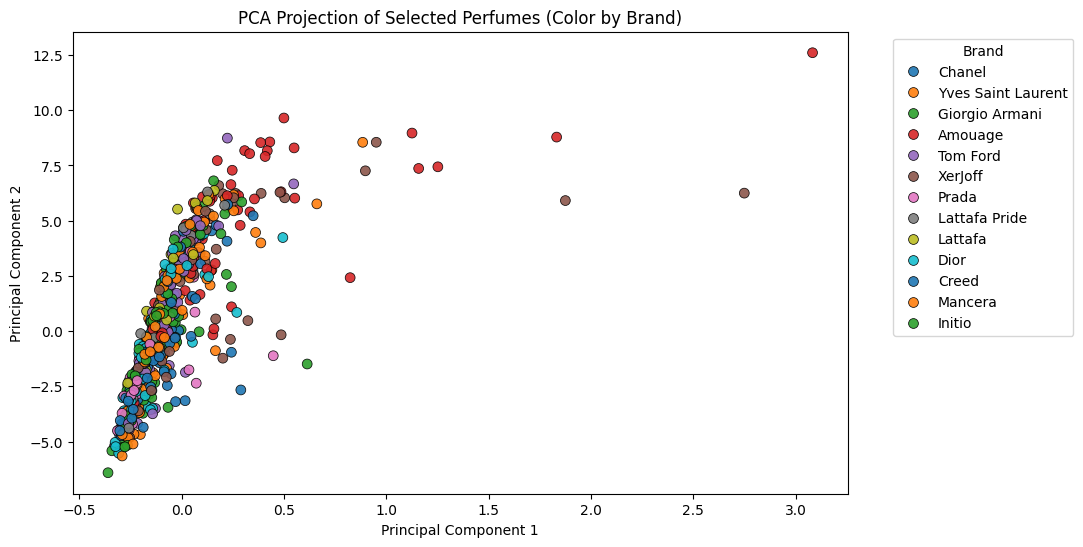

In [22]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df_pca_filtered['PC1'], y=df_pca_filtered['PC2'],
    hue=df_pca_filtered['Brand'], palette='tab10', 
    s=50, alpha=0.9, edgecolor="black"
)

plt.title("PCA Projection of Selected Perfumes (Color by Brand)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['pricing' 'durability' 'sillage' 'bottle' 'scent']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


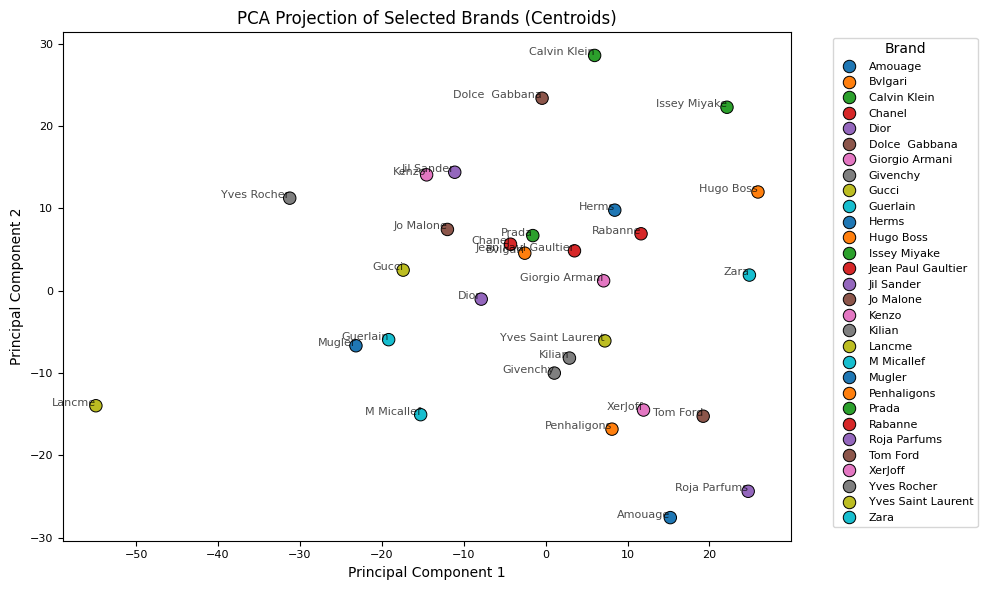

In [23]:
# Step 1: Find the Top 30 Most Frequent Brands
top_brands = df['brand'].value_counts().index[:30]

# Step 2: Filter the Dataset for Selected Brands
filtered_df = df[df['brand'].isin(top_brands)].copy()

# Step 3: Select Only Numeric Features for PCA
numeric_cols = numeric_df.columns
X = filtered_df[numeric_cols]

# Step 4: Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 5: Apply PCA on the imputed data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_imputed)
filtered_df['PC1'] = pca_result[:, 0]
filtered_df['PC2'] = pca_result[:, 1]

# Step 6: Compute Brand Centroids
brand_centroids = filtered_df.groupby('brand')[['PC1', 'PC2']].mean().reset_index()

# Step 7: Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=brand_centroids['PC1'], y=brand_centroids['PC2'], 
    hue=brand_centroids['brand'], palette='tab10', 
    s=80, edgecolor='black'
)

# Annotate each brand at its centroid with smaller font size
for i in range(len(brand_centroids)):
    plt.text(brand_centroids['PC1'].iloc[i], brand_centroids['PC2'].iloc[i], 
             brand_centroids['brand'].iloc[i], fontsize=8, ha='right', alpha=0.7)

plt.title("PCA Projection of Selected Brands (Centroids)", fontsize=12)
plt.xlabel("Principal Component 1", fontsize=10)
plt.ylabel("Principal Component 2", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

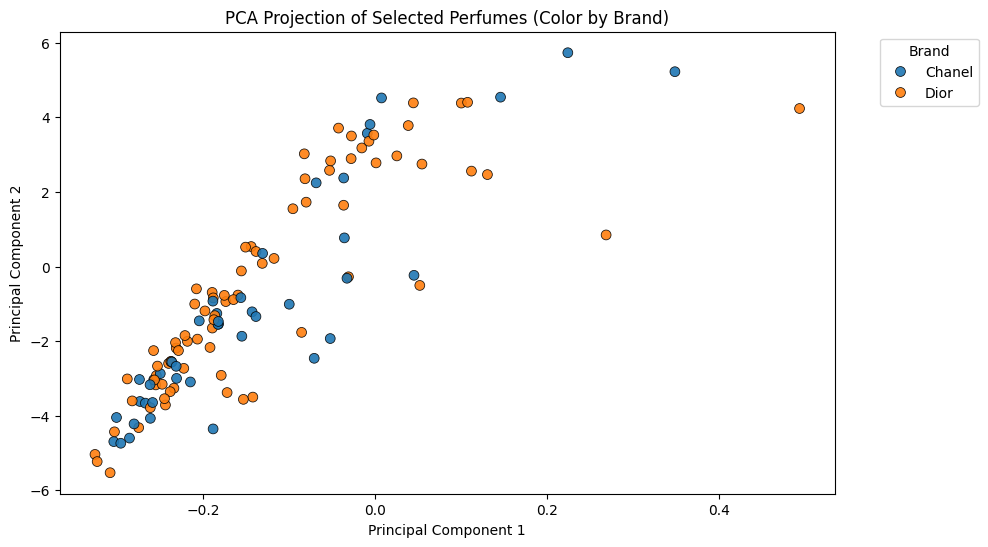

In [24]:
selected_brands = ["Dior", "Chanel"]

df_pca_filtered = df_pca[df_pca['Brand'].isin(selected_brands)]

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df_pca_filtered['PC1'], y=df_pca_filtered['PC2'],
    hue=df_pca_filtered['Brand'], palette='tab10', 
    s=50, alpha=0.9, edgecolor="black"
)

plt.title("PCA Projection of Selected Perfumes (Color by Brand)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [26]:
loadings = pca.components_

In [29]:
print(loadings[0])

[0.00109303 0.00059133 0.00102562 ... 0.         0.         0.        ]


In [36]:
sorted_indices = np.argsort(np.abs(loadings[0]))[::-1]
# sorted_columns = feature_df.columns[np.array(sorted_indices).flatten()]
sorted_columns = feature_df.columns[sorted_indices]

print(sorted_columns.tolist())  #

['Sommer', 'Herbst', 'Winter', 'Herren', 'Orientalisch', 'Pudrig', 'Klassisch', 'Harzig', 'Blumig', 'Erdig', 'pricing', 'Täglich', 'Modern', 'Frühling', 'Freizeit', 'Abend', 'Cremig', 'Arbeit', 'Animalisch', 'Chypre', 'Ausgehen', 'Ledrig', 'Fougère', 'Gourmand', 'Damen', 'Sport', 'Holzig', 'Aquatisch', 'durability', 'Synthetisch', 'Rauchig', 'bottle', 'sillage', 'Süß', 'Fruchtig', 'Lavendel', 'Kardamom', 'Vetiver', 'Zitrus', 'Leder', 'Vanille', 'Grün', 'Zedernholz', 'Jasmin', 'weißer Moschus', 'Patchouli', 'Zitrone', 'Rosengeranie', 'Rose', 'Grapefruit', 'Zimt', 'brand_Lancme', 'brand_Zara', 'Orangenblüte', 'Pfingstrose', 'Muskat', 'Weihrauch', 'Würzig', 'Mandarine', 'brand_Guerlain', 'Salbei', 'Ylang-Ylang', 'Ingwer', 'Tonkabohne', 'Bergamotte', 'Eichenmoos', 'Guajakholz', 'schwarzer Pfeffer', 'Birne', 'Labdanum', 'perfumer_Thierry Wasser', 'Rosmarin', 'Freesie', 'Jasmin-Sambac', 'Wacholderbeere', 'Tabak', 'Muskatellersalbei', 'Tuberose', 'Zypresse', 'Minze', 'Heliotrop', 'Amber', 'Ze

In [37]:
sorted_columns

Index(['Sommer', 'Herbst', 'Winter', 'Herren', 'Orientalisch', 'Pudrig',
       'Klassisch', 'Harzig', 'Blumig', 'Erdig',
       ...
       'brand_Aaron Terence Hughes', 'brand_Abercrombie  Fitch',
       'brand_Adi ale Van', 'brand_Acca Kappa', 'brand_Acqua dellElba',
       'brand_Acqua di Parma', 'brand_Acqua di Stresa', 'brand_Adam Bensahili',
       'brand_Adam Levine', 'indonesisches Oud'],
      dtype='object', length=5231)

In [38]:
sorted_indices

array([  12,   11,   10, ..., 3377, 3378, 2615])

In [42]:
loadings[0][10]

-0.1642958994313871